In [1]:
import librosa
import librosa.display
import os
import pandas as pd
import numpy as np
from time import time 
import random as rd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import threading
from sklearn.metrics import confusion_matrix,accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

path_to_db_voice = "D:\\Utilisateurs\\ENAC\\projet_AIRBUS\\db\\voice\\"
path_to_db_plane = "D:\\Utilisateurs\\ENAC\\projet_AIRBUS\\db\\plane\\"
path_to_db_both = "D:\\Utilisateurs\\ENAC\\projet_AIRBUS\\db\\both\\"

l_voice_records = os.listdir(path_to_db_voice)
l_airplane_records = os.listdir(path_to_db_plane)
l_both_records = os.listdir(path_to_db_both)

In [3]:
#coupe le set en train/test en se basant sur le ratio test_size d'enregistrements que l'on veut pour le set de test

def separe_train_test(db_folder_path,n_records,test_size):
    l_records = os.listdir(db_folder_path)
    sub_l_records = rd.sample(l_records,n_records)
    size = len(sub_l_records)
    sep = round(test_size*size)
    sample = rd.sample(sub_l_records,size)
    test = sample[:sep]
    train = sample[sep:]
    return train,test

In [2]:
def gen_X_train_test(db_folder_path,n_records,test_size):
    sp_rec_train = []
    sp_rec_test = []
    records_train,records_test = separe_train_test(db_folder_path,n_records,test_size)
    i = 0
    for record in records_train:
        print('Building train {}/{}'.format(i,len(records_train)),end='\r')
        #on load l'audio du type voulu
        signal,sample_rate = librosa.load(db_folder_path + record)
        #on applique une STFT
        spectrum = librosa.stft(y=signal) 
        #on le convertit en flottant car la sortie est complexe
        spectrum = spectrum.astype(float)
        #on transpose pour obtenir un vecteur de la forme qu'il faut pour la random forest
        sp_rec_train.append(np.abs(np.transpose(spectrum)))
        i+=1
    i=0
    for record in records_test: 
        print('Building  test {}/{}'.format(i,len(records_test)),end='\r')
        signal,sample_rate = librosa.load(db_folder_path + record)
        spectrum = librosa.stft(y=signal,center=False) 
        spectrum = spectrum.astype(float)
        sp_rec_test.append(np.abs(np.transpose(spectrum)))
        i+=1

    X_train = np.concatenate(sp_rec_train)
    X_test = np.concatenate(sp_rec_test)

    return X_train,X_test

In [20]:
n_records = 150

X_voice_train,X_voice_test= gen_X_train_test(path_to_db_voice,n_records,0.2)
print('Voice done',end='\r')
X_plane_train,X_plane_test = gen_X_train_test(path_to_db_plane,n_records,0.2)
print('Plane done',end='\r')
X_both_train,X_both_test = gen_X_train_test(path_to_db_both,n_records,0.2)
print('Both done',end='\r')

In [29]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.model_selection import train_test_split

y_voice_train = [1 for elt in X_voice_train]
y_plane_train = [0 for elt in X_plane_train]
y_both_train = [1  for elt in X_both_train]

y_voice_test = [1 for elt in X_voice_test]
y_plane_test = [0 for elt in X_plane_test]
y_both_test = [1 for elt in X_both_test]

X_train = np.concatenate([X_voice_train,X_plane_train,X_both_train])
X_test = np.concatenate([X_voice_test,X_plane_test,X_both_test])

y_train =y_plane_train + y_both_train
y_test =y_plane_test + y_both_test


PARTIE MODELE

In [30]:
from sklearn.tree import DecisionTreeClassifier

rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=50, n_jobs=-1)

In [31]:
from sklearn.metrics import accuracy_score

pred = rf.predict(X_plane_test)
print(accuracy_score(pred,y_plane_test))

pred = rf.predict(X_both_test)
accuracy_score(pred,y_both_test)

0.5209271602714226


0.840700791819939

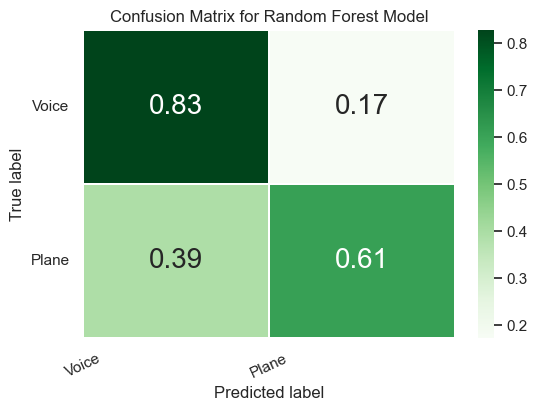

In [28]:
#code pour la matrice de confusion

pred = rf.predict(X_test)
matrix = confusion_matrix(pred,y_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(6,4))
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, annot_kws={'size':20},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Voice','Plane']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [4]:
import joblib 

# rf = joblib.load("random_forest.joblib")
joblib.dump(rf, "random_forest2.joblib")

NameError: name 'rf' is not defined

TEST DE LA RF SAUVEGARDEE

In [5]:
import joblib 

rf = joblib.load("random_forest2.joblib")
# joblib.dump(rf, "random_forest.joblib")


In [6]:
n_records = 100

X_plane_train,X_plane_test = gen_X_train_test(path_to_db_plane,n_records,0.9)
print('Plane done',end='\r')
X_both_train,X_both_test = gen_X_train_test(path_to_db_both,n_records,0.9)
print('Both done',end='\r')

In [7]:
only_voice = 'Voice'
only_plane = 'Plane'
both_classes = 'Voice'

y_plane_train = np.array([only_plane for elt in X_plane_train])
y_both_train = np.array([both_classes for elt in X_both_train])

y_plane_test = np.array([only_plane for elt in X_plane_test])
y_both_test = np.array([both_classes for elt in X_both_test])

X_train = np.concatenate([X_plane_train , X_both_train])
X_test = np.concatenate([X_plane_test , X_both_test])

y_train = np.concatenate([y_plane_train , y_both_train])
y_test =np.concatenate([y_plane_test , y_both_test])

In [8]:
pred = rf.predict(X_test)
print('Accuracy :',accuracy_score(pred,y_test))

Accuracy : 0.6764878112258177


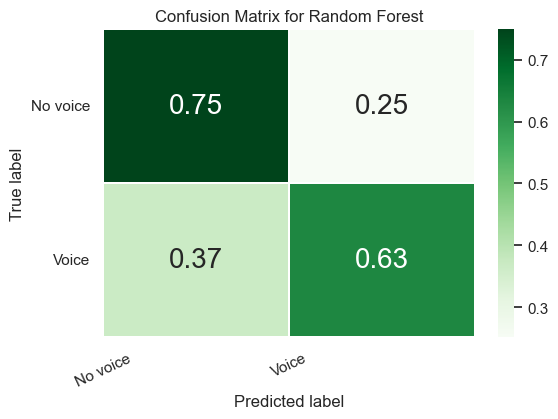

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

matrix = confusion_matrix(pred,y_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(6,4))
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, annot_kws={'size':20},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['No voice', 'Voice']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest')
plt.show()

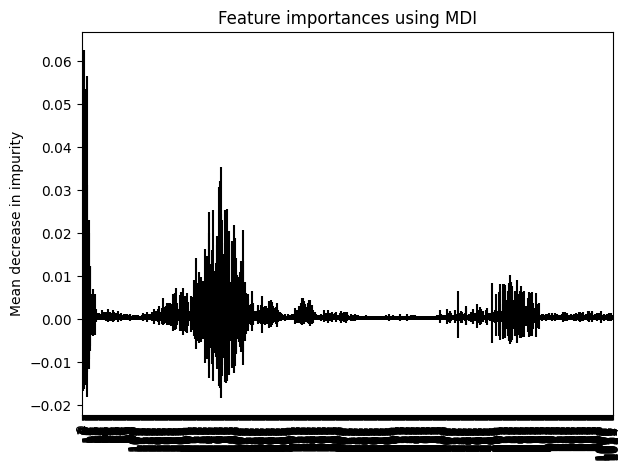

In [6]:
import pandas as pd
feature_names = [f"fréquence {i}" for i in range(1025)]
forest_importances = pd.Series(rf.feature_importances_)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [14]:
# len(rf.feature_importances_),rf.feature_importances_[:20]
importances_index = [i[0] for i in sorted(enumerate(rf.feature_importances_), key=lambda x:x[1])]

<BarContainer object of 20 artists>

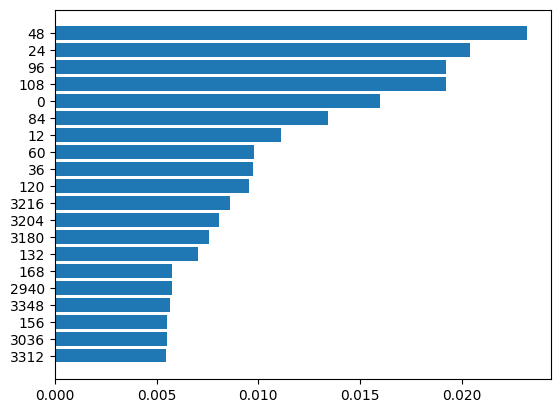

In [27]:
plt.barh([str(12*elt) for elt in importances_index[-20:]],[rf.feature_importances_[elt] for elt in importances_index[-20:]])

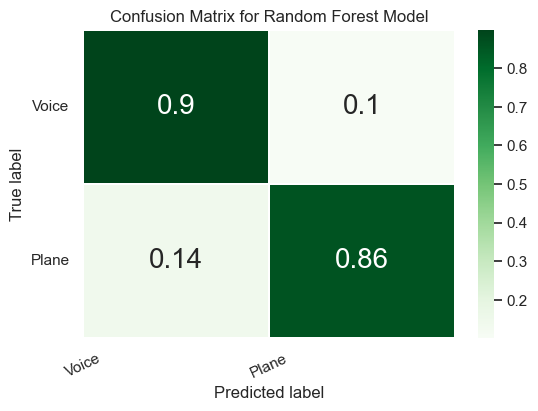

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
pred = rf.predict(X_test)
matrix = confusion_matrix(pred,y_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(6,4))
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, annot_kws={'size':20},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Voice','Plane']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [2]:
def has_voice(x,hop,duration_sec_threshold,error_threshold):
    ratio = np.count_nonzero(x=='Voice')/len(x)
    duration_discrete_threshold = duration_sec_threshold * 22050 / hop
    if len(x) >duration_discrete_threshold and ratio > error_threshold:
        print('Durée de la voix: ',len(x)*hop/22050,'seconds')
        return True
    elif len(x)<duration_discrete_threshold:
        return False
    else:
        half = len(x)//2
        return has_voice(x[:half],hop,duration_sec_threshold,error_threshold) or has_voice(x[half:],hop,duration_sec_threshold,error_threshold)

def has_voice2(x,hop,duration_sec_threshold,error_threshold):
    ratio = np.count_nonzero(x=='Voice')/len(x)
    duration_discrete_threshold = round(duration_sec_threshold * 22050 / hop)
    #conversion de sortie en string en sortie binaire (0 et 1)
    binary_pred = [0 if elt=='Plane' else 1 for elt in x]
    df_x = pd.DataFrame(binary_pred)
    #fenêtre glissante
    df_sum = df_x.rolling(duration_discrete_threshold).mean()
    x_plot = [elt*hop/22050 for elt in range(len(x))] #x en seconds

    return len(df_sum[df_sum[0]>error_threshold])>0

def gen_valid_test(db_folder_path,n_records):

    l_records = os.listdir(db_folder_path)
    sub_l_records = rd.sample(l_records,n_records)
    sample = rd.sample(sub_l_records,n_records)
    sp_valid = []
    hops_valid = []
    for i in range(n_records):
        print('Building validation set {}/{}'.format(i,n_records),end='\r')
        signal,sample_rate = librosa.load(db_folder_path + sample[i])
        spectrum = librosa.stft(y=signal,center=False) 
        spectrum = spectrum.astype(float)
        good_shape_spectrum = np.abs(np.transpose(spectrum))
        sp_valid.append(good_shape_spectrum)
        hops_valid.append(len(signal)//len(good_shape_spectrum))

    return sp_valid,hops_valid

def valid_model(model,duration_threshold,error_threshold,n_records):

    plane_valid,hops_plane = gen_valid_test(path_to_db_plane,n_records)
    both_valid,hops_both = gen_valid_test(path_to_db_both,n_records)

    target_plane = [False for elt in plane_valid]
    target_both = [True for elt in both_valid]
    
    records_valid = plane_valid + both_valid
    target_valid =  target_plane + target_both
    hops_valid = hops_plane + hops_both

    prediction_for_records_plane = []
    for i  in range(len(plane_valid)):
        pred = model.predict(plane_valid[i])
        prediction_for_records_plane.append(has_voice2(pred,hops_plane[i],duration_threshold,error_threshold))

    prediction_for_records_both = []
    for i  in range(len(both_valid)):
        pred = model.predict(both_valid[i])
        prediction_for_records_both.append(has_voice2(pred,hops_both[i],duration_threshold,error_threshold))

    return accuracy_score(target_plane,prediction_for_records_plane),accuracy_score(target_both,prediction_for_records_both)

In [5]:
valid_model(rf,1,0.9,10)

(0.8, 1.0)

In [ ]:
#foncion de parameter tuning pour savoir quels thresholds on va prendre

def hyper_tune_valid(model,n_records,n_iter):
    
    dur_range = np.linspace(1,5,6)
    thresh_range = np.linspace(0.5,1,20)

    best_dur,best_thresh,best_valid = 0,0,0

    for i in range(n_iter):
        
        if best_valid ==1:
            return best_dur,best_thresh,best_valid

        dur = rd.choice(dur_range)
        thresh = rd.choice(thresh_range)
        val = valid_model(model,dur,thresh,n_records)

        if val > best_valid:
            best_valid = val
            best_dur = dur
            best_thresh = thresh

    return best_dur,best_thresh,best_valid